In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
from masks import SegmentationToDetectionDataset
from masks import COLORS
from torchvision.ops import _box_convert

1.10.2 False


In [2]:
batch_size = 1
# Choose whether to start indexing categories with 0 or with 1.
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 1

In [3]:
import albumentations as A
import cv2

# Add transforms in the code later
transform = A.Compose([
    # A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


In [4]:
from torch.utils.data import DataLoader
train_path = "/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset"
train_data = SegmentationToDetectionDataset(train_path, transforms=transform)
# valid_data = SegmentationToDetectionDataset(valid_path, transform=transform)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
print("len(train_data)",len(train_data), "len(train_loader)", len(train_loader))

len(train_data) 1443 len(train_loader) 1443


[(639.2265701293945, 0.4083333257585764, 639.7499847412109, 0.8895833417773247), (639.235954284668, 0.42916668578982353, 639.743766784668, 0.8625000156462193), (639.2296981811523, 0.4124999977648258, 639.7468566894531, 0.8833333477377892)]
Feature batch shape: torch.Size([1, 3, 480, 640])
Labels batch shape: torch.Size([1, 3])
Label: tensor([1, 1, 1])


<ipython-input-45-75364f33b76d>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  drawn_boxes = draw_bounding_boxes(torch.tensor(img*255, dtype=torch.uint8), boxes.clone().detach(), colors="red")


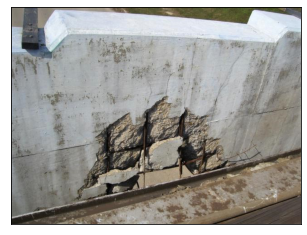

In [45]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from albumentations.augmentations.bbox_utils import denormalize_bbox
from masks import show

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels['labels'].size()}")
img = train_features[0].squeeze()
label = train_labels['labels'][0]
# plt.imshow(img.permute(1,2,0), cmap="gray")
# plt.show()
boxes = train_labels['boxes'][0]
for i, box in enumerate(boxes):
    boxes[i] = torch.tensor(denormalize_bbox(box,img.shape[1], img.shape[2]))
# bbox = denormalize_bbox(train_labels['boxes'])
# boxes = torch.stack(boxes)
for i, box in enumerate(boxes):
    boxes[i] = _box_convert._box_xywh_to_xyxy(box)

drawn_boxes = draw_bounding_boxes(torch.tensor(img*255, dtype=torch.uint8), boxes.clone().detach(), colors="red")
show(drawn_boxes)
print(f"Label: {label}")

In [ ]:
# Get pretrained weights
# checkpoint = torch.hub.load_state_dict_from_url(
#             url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
#             map_location='cpu',
#             check_hash=True)

# # Remove class weights
# del checkpoint["model"]["class_embed.weight"]
# del checkpoint["model"]["class_embed.bias"]

# # Save
# torch.save(checkpoint, 'detr-r50_no-class-head.pth')

In [47]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 3

  finetuned_classes = ['spall', 'rebar', 'crack']

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 4

  finetuned_classes = ['N/A', 'spall', 'rebar', 'crack']

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 4
Fine-tuned classes: ['N/A', 'spall', 'rebar', 'crack']


In [ ]:
!python main_detr.py \
  --dataset_file "coco" \
  --data_path "/home/francis/Documents/Atom360/code/Dataset/buildings/Building dataset/dataset" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10 \
  --batch_size 1